<a href="https://colab.research.google.com/github/adasegroup/ML2021_seminars/blob/master/seminar5/Trees_Bagging_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar: Trees, Bootstrap Aggregation (Bagging) and Random Forest
Machine Learning by professor Evgeny Burnaev
<br\>
Author: Andrey Lange

In [ ]:
! pip install --upgrade scikit-learn

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 5)

# Example 1: Regression tree

          x1         y
0   1.646441  0.192209
1   2.145568 -0.743480
..       ...       ...
98  2.486820  1.053474
99  0.014086  0.104399

[100 rows x 2 columns]


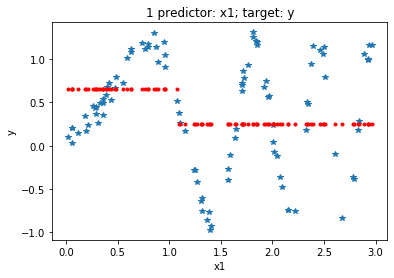

Mean Squared Error:  0.3550636421014569


In [2]:
# prepare and show a dataset
n = 1                         # number of features
N = 100**n                    # number of samples
np.random.seed(0)
X = np.random.random((N, n))*3
coeffs = 1 +  2 * np.random.random((n, 1))
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))/3
y = y.ravel()
print((pd.DataFrame({'x1': X[:, 0], 'y': y})))
plt.plot(X, y, '*')
plt.title('1 predictor: x1; target: y')
plt.xlabel('x1')
plt.ylabel('y')

# train and predict a regression tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

clf = DecisionTreeRegressor(max_depth=1)
clf.fit(X, y)
y_pred = clf.predict(X)

plt.plot(X, y_pred, '.r')
plt.show()

print('Mean Squared Error: ', mean_squared_error(y, y_pred))

### Question 1.1: Change the number of levels in a regression tree above until the best approximation of the training set. What is the best MSE?

### Question 1.2: Calculate MSE above without `mean_squared_error()` calling.

## Example 2: Regression tree with $n=2$ features

### Question 2.1: Lets try an example with $n=2$ features. Train a regression stump (a tree of a depth 1) and see the optimal threshold (border between colors) for the best feature chosen for split among $x_1$ and $x_2$. What feature was chosen and why? Change something in the string 
```
coeffs = np.array([[0.2], [1.5]])
```
### to make another feature is chosen as the best for split.



### Question 2.2: Find the optimal `max_depth` hyperparameter when MSE on the training set is the best.

            x1        x2         y
0     0.987864  1.287341  0.575163
1     1.084974  0.980790  1.007940
...        ...       ...       ...
9998  0.536880  0.803620  1.100161
9999  0.648228  1.126596  1.127278

[10000 rows x 3 columns]


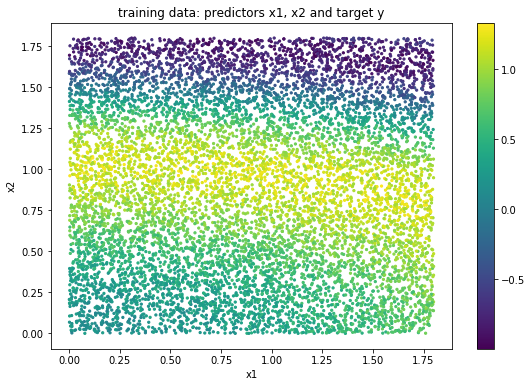

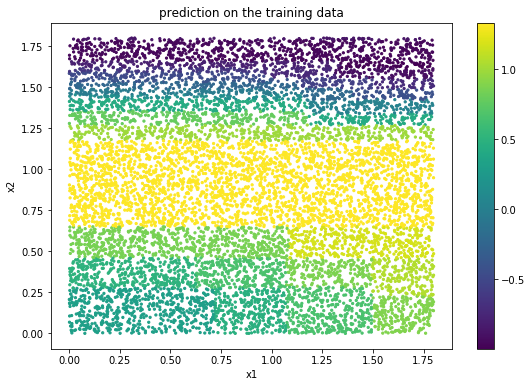

Mean Squared Error:  0.016911218331871206


In [11]:
# prepare and show a dataset in 2D
n = 2               # number of features
N = 100**n          # number of samples
np.random.seed(0)
X = np.random.random((N, n))*1.8

# Change something to make another feature is chosen for split by some optimal threshold
coeffs = np.array([[0.2], [1.5]])
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))/3

# print dataset
print((pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y.ravel()})))

# show target y in (x1, x2) space
plt.figure(figsize=[9, 6])
sc = plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=5)
plt.colorbar(sc)
plt.title('training data: predictors x1, x2 and target y')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# train and predict by a regression tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X, y)
y_pred = clf.predict(X)

# show prediction in (x1, x2) space
plt.figure(figsize=[9, 6])
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=5)
plt.colorbar(sc)
plt.title('prediction on the training data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

print('Mean Squared Error: ', mean_squared_error(y, y_pred))

## Example 3: Regression tree: training and testing sets

### Question 3.1: Now we consider training and testing sets. Try different depths of a decision tree to see when the model is underfitted and when the one is overfitted to the training set. Plot the MSE on the testing set depending on `max_depth` hyperparameter. What is the optimal value?

train MSE:  0.4821449201053893
test MSE:  0.42332022041738254


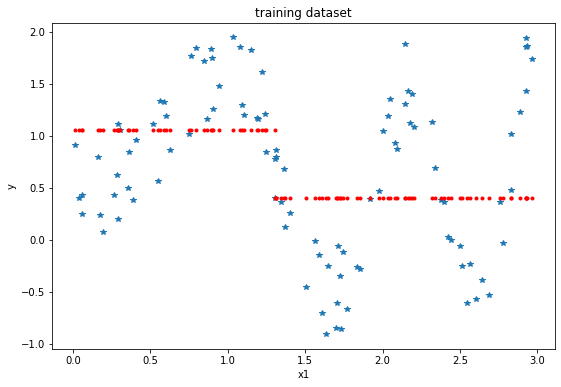

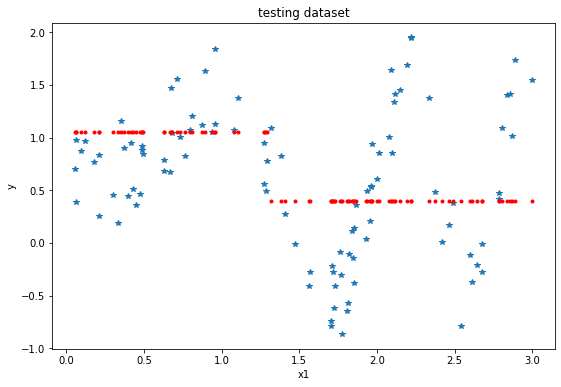

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# prepare dataset
n = 1                         # number of features
N = 200**n                    # number of samples
np.random.seed(0)
X = np.random.random((N, n))*3
coeffs = 1 +  2 * np.random.random((n, 1))
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=0)

# --- change this block to select the best max_depth
clf = DecisionTreeRegressor(max_depth=1)
clf.fit(X_train, y_train)
print('train MSE: ', mean_squared_error(y_train, clf.predict(X_train)))
print('test MSE: ', mean_squared_error(y_test, clf.predict(X_test)))
# ---

plt.figure(figsize=[9, 6])
plt.plot(X_train, y_train, '*')
plt.plot(X_train, clf.predict(X_train), '.r')
plt.title('training dataset')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

plt.figure(figsize=[9, 6])
plt.plot(X_test, y_test, '*')
plt.plot(X_test, clf.predict(X_test), '.r')
plt.title('testing dataset')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

### Question 3.2. How many constant-valued regions of red points are on the picture when `max_depth=5`?



# Example 4: Bagging = Decision Tree + Bootstrap
### In the question above we've found the optimal `max_depth` for the case of single Decision Tree. By limiting the tree depth we distort the fitting to the training dataset and prevent the model from overfitting. 
### The second way to prevent overfitting is to distort the ... training dataset itself. What is Bagging?
### We train many trees each on a Bootstraped training dataset (it contains the same number of samples but some of them are included with some number of their copies, and some of them are not included). Then we average over all such trees. It is called Bootstrap aggregation - Bagging.

### Question 4.1: Compare the prediction above (single tree) with Bagging all with `max_depth=5`. Why Bagging approximation red dots does not look like constant-valued regions as in a single decision tree? Tune the best number of trees. Has  Bagging improved the single tree model regarding `test MSE`?

### Question 4.2: Sometimes it is good to be a perfectionist and unittest any code :). Unittest scikit-learn! Should `DecisionTreeRegressor` and `BaggingRegressor`  give the same results in some special case? Simplify Bagging to the single Decision Tree and show the same pictures as above when `max_depth=5`. What parameter `n_estimators` have to be set to? Do we need to change any other hyperparameters?

train MSE:  0.022072951953077298
test MSE:  0.1484391082648324


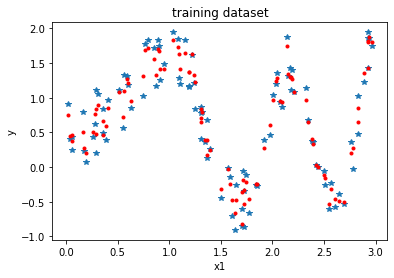

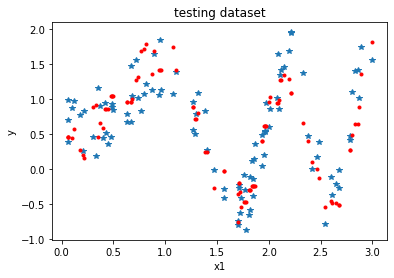

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# prepare dataset
n = 1                         # number of features
N = 200**n                    # number of samples
np.random.seed(0)
X = np.random.random((N, n))*3
coeffs = 1 +  2 * np.random.random((n, 1))
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=0)

# --- 1. change this block to select the best n_estimators
# --- 2. change this block to simplify Bagging to ordinary single decision tree
clf = BaggingRegressor(DecisionTreeRegressor(max_depth=12), n_estimators=10, bootstrap=True, random_state=0)
clf.fit(X_train, y_train.ravel())
print('train MSE: ', mean_squared_error(y_train, clf.predict(X_train)))
print('test MSE: ', mean_squared_error(y_test, clf.predict(X_test)))
# ---

# plt.figure(figsize=[9, 6])
plt.plot(X_train, y_train, '*')
plt.plot(X_train, clf.predict(X_train), '.r')
plt.title('training dataset')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

# plt.figure(figsize=[9, 6])
plt.plot(X_test, y_test, '*')
plt.plot(X_test, clf.predict(X_test), '.r')
plt.title('testing dataset')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

### Question 4.3: Estimate the part of points that are not selected after Bootstrap procedure analytically. Consider the sample of a size $N\to\infty$.

# Example 5: Random Forest = Bagging + (`max_features' < $n$)

## Can we reduce the overfitting more? - YES!!! <br> Along with Bootstrap reduce the number of features among which the best feature for each tree in ensemble is chosen!

### Question 5.1: Tune `max_features` to improve the tesing MSE. Check that testing MSE becomes better. And what happens with training MSE and why?

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# prepare dataset
n = 100           # number of features
N = 10**4         # number of samples
np.random.seed(0)
X = np.random.random((N, n))*3
coeffs = 1 +  2 * np.random.random((n, 1))
y = np.sin(np.matmul(X*X, coeffs)) + np.random.random((N, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/2, random_state=0)

# --- change this block to select the best max_features
clf = RandomForestRegressor(max_depth=5, n_estimators=10, max_features=n, random_state=0)
clf.fit(X_train, y_train.ravel())
print('train MSE: ', mean_squared_error(y_train, clf.predict(X_train)))
print('test MSE: ', mean_squared_error(y_test, clf.predict(X_test)))
# ---

train MSE:  0.523909750433318
test MSE:  0.5915306241928471


## Random Forest on Kaggle data

### Below shorter trees and 'max_features' <  all features performs better.

best parameters: {'max_depth': 10, 'max_features': 'auto'}
ROC_AUC score: 0.7095951747496287


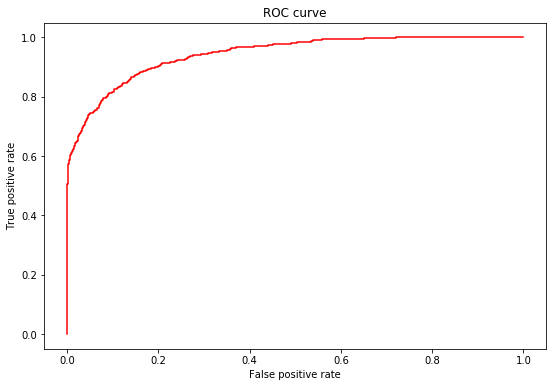

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

X_train = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2021_seminars/master/seminar5/give_me_some_credit.csv', index_col=0)
X_train = X_train.dropna()
y_train = X_train['SeriousDlqin2yrs']
X_train = X_train.drop(['SeriousDlqin2yrs'], axis=1)

X_train = X_train.iloc[::10, :] # use only each 10th sample to save a time
y_train = y_train.iloc[::10] 

n_features = X_train.shape[1]
clf = GridSearchCV(RandomForestClassifier(random_state=0),
                   # you can play with tuning, up to your CPU performance:
                   {'max_depth': [10, 15], 'max_features': ['auto', n_features]},
                   scoring = 'roc_auc',
                   cv = 3, 
                   n_jobs=-1)
# You can see below that detailed trees i.e. with high depth and all features on a split are worse, 
# GridSearchCV() choses shorter depth and sqrt() of all features.
# This is because we use cross-validation (cv=3), and it prevents from overfitting

clf.fit(X_train, y_train)
print('best parameters:', clf.best_params_)
print('ROC_AUC score:', roc_auc_score(y_train, clf.predict(X_train)))

# now let's draw ROC curve
plt.figure(figsize=[9, 6])
fpr, tpr, _ = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, 'r', label='train')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# Example 6: Feature Importance

ROC_AUC score: 0.7095951747496287


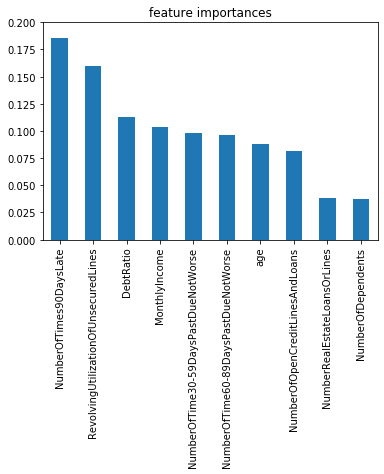

In [8]:
X_train = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2021_seminars/master/seminar5/give_me_some_credit.csv', index_col=0)
y_train = X_train['SeriousDlqin2yrs']
X_train = X_train.drop(['SeriousDlqin2yrs'], axis=1)

X_train = X_train.iloc[::10, :] # use only each 10th sample to save a time
y_train = y_train.iloc[::10] 

clf = RandomForestClassifier(max_depth = 10, max_features = 'auto', random_state=0)
clf.fit(X_train, y_train)
print('ROC_AUC score:', roc_auc_score(y_train, clf.predict(X_train)))

# feature importances
fi = pd.Series(clf.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).plot(kind='bar')
plt.title('feature importances')
plt.ylim([0, 0.2])
plt.show()

### Be careful with `feature_importances`: after adding extremly correlated features (here they are even copies) the values of importance decrease (see the scale along vertical axis). This is expected, because similar features can share their common similar importance.

ROC_AUC score: 0.6925751768840326


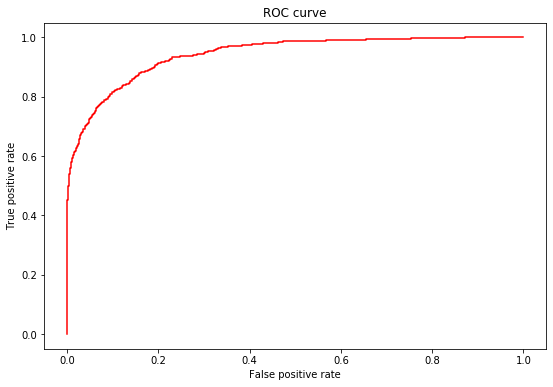

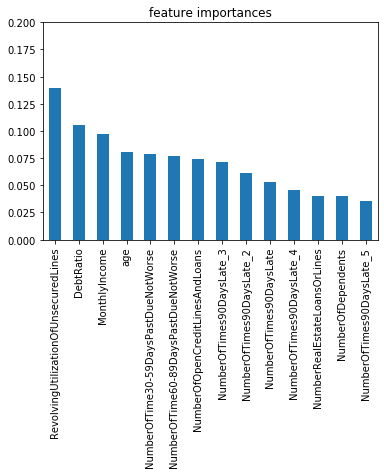

In [9]:
X_train = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2021_seminars/master/seminar5/give_me_some_credit.csv', index_col=0)
X_train = X_train.dropna()
y_train = X_train['SeriousDlqin2yrs']
X_train = X_train.drop(['SeriousDlqin2yrs'], axis=1)

X_train = X_train.iloc[::10, :] # use only each 10th sample to save a time
y_train = y_train.iloc[::10] 

X_train['NumberOfTimes90DaysLate_2'] = X_train['NumberOfTimes90DaysLate']
X_train['NumberOfTimes90DaysLate_3'] = X_train['NumberOfTimes90DaysLate']
X_train['NumberOfTimes90DaysLate_4'] = X_train['NumberOfTimes90DaysLate']
X_train['NumberOfTimes90DaysLate_5'] = X_train['NumberOfTimes90DaysLate']

clf = RandomForestClassifier(max_depth = 10, max_features = 'auto', random_state=0)
clf.fit(X_train, y_train)
print('ROC_AUC score:', roc_auc_score(y_train, clf.predict(X_train)))

# now let's draw ROC curve
plt.figure(figsize=[9, 6])
fpr, tpr, _ = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, 'r', label='train')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# feature importances
fi = pd.Series(clf.feature_importances_, index=X_train.columns)
fi.sort_values(ascending=False).plot(kind='bar')
plt.title('feature importances')
plt.ylim([0, 0.2])
plt.show()

## Feature Selection and Feature Importance

### Above, the feature 'NumberOfTimes90DaysLate' moved from the top to the tail together with its highly correlated (even cloned) 'friends'. Now they share their importance together. Do not think that top features are really strong and tail ones are weak! The can correlate significantly. 

### So, do not rely only on Feature Importance! Try to reduce the dimension, for. ex. by Feature Selection

### In the following example if sequentially add the strongest feature one can recover the original feature set

ROC_AUC score: 0.7095951747496287


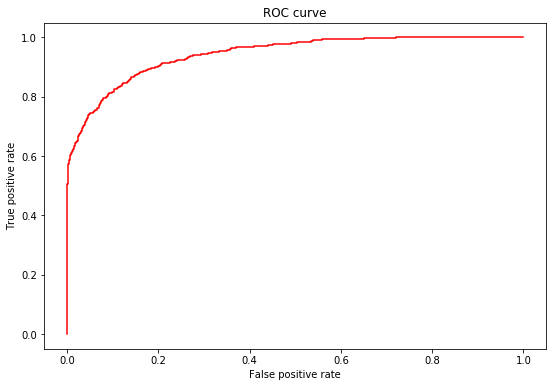

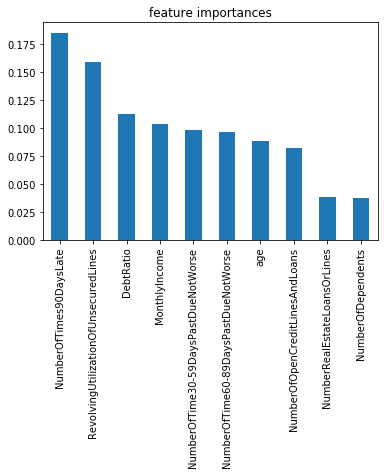

In [10]:
# from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_curve, roc_auc_score

X_train = pd.read_csv('https://raw.githubusercontent.com/adasegroup/ML2021_seminars/master/seminar5/give_me_some_credit.csv', index_col=0)
X_train = X_train.dropna()
y_train = X_train['SeriousDlqin2yrs']
X_train = X_train.drop(['SeriousDlqin2yrs'], axis=1)

X_train = X_train.iloc[::10, :] # use only each 10th sample to save a time
y_train = y_train.iloc[::10] 

X_train['NumberOfTimes90DaysLate_2'] = X_train['NumberOfTimes90DaysLate']
X_train['NumberOfTimes90DaysLate_3'] = X_train['NumberOfTimes90DaysLate']
X_train['NumberOfTimes90DaysLate_4'] = X_train['NumberOfTimes90DaysLate']
X_train['NumberOfTimes90DaysLate_5'] = X_train['NumberOfTimes90DaysLate']

clf = RandomForestClassifier(max_depth = 10, max_features ='auto', random_state = 0)
clf_SFS = SequentialFeatureSelector(clf, n_features_to_select=10, direction='forward', scoring='roc_auc', cv=3, n_jobs=-1)
# clf = RFE(clf, n_features_to_select=3, step=1)
clf_SFS.fit(X_train, y_train)
X_selected = X_train.iloc[:, clf_SFS.get_support()]

clf.fit(X_selected, y_train)
print('ROC_AUC score:', roc_auc_score(y_train, clf.predict(X_selected)))

# now let's draw ROC curve
plt.figure(figsize=[9, 6])
fpr, tpr, _ = roc_curve(y_train, clf.predict_proba(X_selected)[:, 1])
plt.plot(fpr, tpr, 'r', label='train')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# feature importances
fi = pd.Series(clf.feature_importances_, index=X_selected.columns)
fi.sort_values(ascending=False).plot(kind='bar')
plt.title('feature importances')
# plt.ylim([0, 0.2])
plt.show()